### Image

In [ ]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt

img = cv2.imread('/home/robotic/Pictures/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.bitwise_not(img)

In [85]:
kernel = np.ones((20,20), np.uint8)
img_dil = cv2.dilate(img, kernel, iterations=1)
img_dil = (img_dil*0.5).astype(np.uint8)
img_res = cv2.add(img, img_dil)


kernel1 = np.ones((40,40), np.uint8)
img_dil1 = cv2.dilate(img, kernel1, iterations=1)
img_dil1 = (img_dil1*0.3).astype(np.uint8)
img_res = cv2.add(img_res, img_dil1)

kernel2 = np.ones((80,80), np.uint8)
img_dil2 = cv2.dilate(img, kernel2, iterations=1)
img_dil2 = (img_dil2*0.1).astype(np.uint8)
img_res = cv2.add(img_res, img_dil2)

### DBSCAN

In [180]:
img = cv2.imread('/home/robotic/Pictures/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.bitwise_not(img)

gray = img
blur = cv2.blur(gray, (3, 3)) # blur the image
ret, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY)

In [183]:
np.unique(thresh)

array([  0, 255], dtype=uint8)

In [209]:
from sklearn.cluster import DBSCAN

x = np.where(thresh==255)
X = np.vstack((x[0], x[1])).T

output = DBSCAN(eps=10, min_samples=2).fit(X)

In [210]:
set(output.labels_)
x[1].shape

(18817,)

In [211]:
output.labels_
X.shape

(18817, 2)

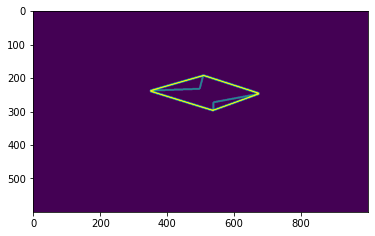

In [303]:
tmp_img = np.zeros((600,1000)).astype(np.uint8)
x1 = X[np.where(output.labels_==1), :][0]
for xy in x1:
    tmp_img[xy[0], xy[1]] = 255

plt.imshow(tmp_img, cmap='gray')

contours, hierarchy = cv2.findContours(tmp_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_show = np.zeros((600,1000), dtype=np.uint8)
img_show = cv2.drawContours(img_show, contours, -1, 125, 3)

hull = cv2.convexHull(contours[0])
img_show = cv2.drawContours(img_show, [hull], -1, 255, 3)
plt.imshow(img_show)

### Lidar point

In [1]:
import numpy as np 
data = np.load('data.npy', allow_pickle=True)
X = []
rads = np.linspace(0,2*np.pi,1972)
for i,rad in enumerate(rads):
    if data[i] < 2:
        # X.append([data[i], rad])
        X.append([data[i]*np.cos(rad), data[i]*np.sin(rad)])
X = np.array(X)
X.shape

(510, 2)

In [19]:
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
import cv2

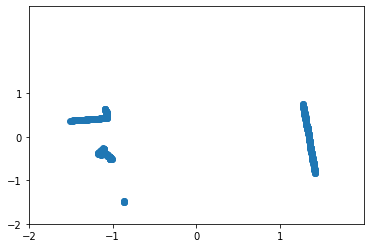

In [4]:
fig, ax = plt.subplots()
ax.scatter(X.T[0], X.T[1])
ax.set(xlim=(-2, 2), xticks=np.arange(-2,2),
       ylim=(-2, 3), yticks=np.arange(-2,2))
plt.show()

In [7]:
output = DBSCAN(eps=0.5, min_samples=5).fit(X).labels_
set(output)

{0, 1, 2, 3}

In [17]:
X.T[0][np.where(output==1)].shape

(93,)

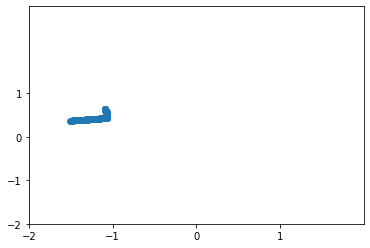

In [10]:
id = 1
fig, ax = plt.subplots()
ax.scatter(X.T[0][np.where(output==id)], X.T[1][np.where(output==id)])
ax.set(xlim=(-2, 2), xticks=np.arange(-2,2),
       ylim=(-2, 3), yticks=np.arange(-2,2))
plt.show()

1
13


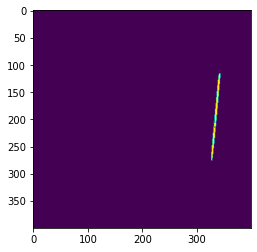

In [24]:
id = 0
scale = 100
x_ = np.int32((X.T[0][np.where(output==id)]+2)*100)
y_ = np.int32((X.T[1][np.where(output==id)]+2)*100)
# x_ = np.int32((X.T[0]+2)*100)
# y_ = np.int32((X.T[1]+2)*100)
img = np.zeros((400,400)).astype(np.uint8)
img[y_,x_] = 255
# plt.imshow(cv2.flip(img, 0), cmap='gray')

kernel = np.ones((5,5))
img = cv2.dilate(img, kernel, iterations=1)
kernel = np.ones((4,4))
img = cv2.erode(img, kernel, iterations=1)

contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
# img_show = cv2.drawContours(img.copy(), contours, -1, 255, 3)
hull = cv2.convexHull(contours[0])
print(len(hull))
img_show = cv2.drawContours(img.copy(), [hull], -1, 255, 1)
plt.imshow(img_show)

In [30]:
hull = hull.reshape((-1,2))
hull

array([[343, 116],
       [343, 119],
       [337, 186],
       [332, 240],
       [329, 268],
       [328, 275],
       [327, 275],
       [327, 266],
       [330, 230],
       [339, 132],
       [340, 123],
       [341, 117],
       [342, 116]], dtype=int32)

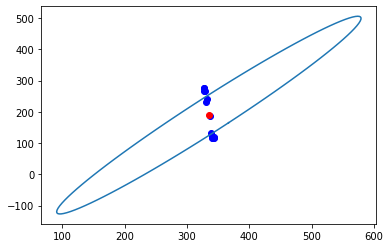

In [112]:
plt.scatter(hull[:,0], hull[:,1], color='blue')
center = np.mean(hull, axis=0)
plt.scatter(center[0], center[1], color='red')
a,b,rot = get_ellipse_params(hull-center)
elip = draw_ellipse(a, b, 75)
plt.plot(elip[:,0]+center[0], elip[:,1]+center[1])


In [82]:
from numpy import pi, cos, sin

def draw_ellipse(a,b,rot):
    rot = (rot/360)*pi
    t = np.linspace(0,2*pi,100)
    R_rot = np.array([[cos(rot), -sin(rot)],[sin(rot), cos(rot)]])
    x = a*cos(t)
    y = b*sin(t)
    xy_rot = np.dot(np.vstack((x,y)).T,R_rot)
    return xy_rot

In [66]:
from sklearn.linear_model import LinearRegression
def get_ellipse_params(points):
        ''' Calculate the parameters needed to graph an ellipse around a cluster of points in 2D.

            Calculate the height, width and angle of an ellipse to enclose the points in a cluster.
            Calculate the width by finding the maximum distance between the x-coordinates of points
            in the cluster, and the height by finding the maximum distance between the y-coordinates
            in the cluster. Multiple both by a scale factor to give padding around the points when
            constructing the ellipse. Calculate the angle by taking the inverse tangent of the
            gradient of the regression line. Note that tangent solutions repeat every 180 degrees,
            and so to ensure the correct solution has been found for plotting, add a correction
            factor of +/- 90 degrees if the magnitude of the angle exceeds 45 degrees.

            Args:
                points (ndarray): The points in a cluster to enclose with an ellipse, containing n
                                  ndarray elements representing each point, each with d elements
                                  representing the coordinates for the point.

            Returns:
                width (float):  The width of the ellipse.
                height (float): The height of the ellipse.
                angle (float):  The angle of the ellipse in degrees.
        '''
        if points.ndim == 1:
            width, height, angle = 0.1, 0.1, 0
            return width, height, angle

        else:
            SCALE = 2.5
            width = np.amax(points[:,0]) - np.amin(points[:,0])
            height = np.amax(points[:,1]) - np.amin(points[:,1])
            
            # Calculate angle
            x_reg, y_reg = [[p[0]] for p in points], [[p[1]] for p in points]
            grad = LinearRegression().fit(x_reg, y_reg).coef_[0][0]
            angle = np.degrees(np.arctan(grad))

            # Account for multiple solutions of arctan
            if angle < -45: angle += 90
            elif angle > 45: angle -= 90

            return width*SCALE, height*SCALE, angle

elip = get_ellipse_params(hull)
elip 

(40.0, 397.5, 5.34485761295204)

In [37]:
elip

(40.0, 397.5, 5.34485761295204)

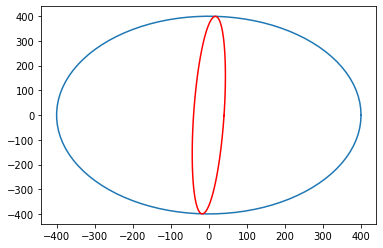

In [65]:
from numpy import pi, cos, sin

def draw_ellipse(x,y,a,b,rot):
    rot = (rot/360)*pi
    t = np.linspace(0,2*pi,100)
    R_rot = np.array([[cos(rot), -sin(rot)],[sin(rot), cos(rot)]])
    x = a*cos(t)
    y = b*sin(t)
    xy_rot = np.dot(np.vstack((x,y)).T,R_rot)
    xy_rot[:,0] += x
    xy_rot[:,1] += y
    return xy_rot

a = 40
b = 400
t = np.linspace(0, 2*pi, 100)

plt.plot(b*cos(t), b*sin(t))

x = a*cos(t)
y = b*sin(t)

t_rot = (5/360)*pi
R_rot = np.array([[cos(t_rot), -sin(t_rot)],[sin(t_rot), cos(t_rot)]])

xy_rot = np.dot(np.vstack((x,y)).T,R_rot)

plt.plot(xy_rot[:,0], xy_rot[:,1], 'r')
plt.show()

In [22]:
xy = np.vstack((x,y)).T